# Single Pixel Study

- [MNIST](#MNIST)
- [CIFAR-10](#CIFAR-10)
- [OTHER](#OTHER)

In [70]:
from IPython.display import display
from ipywidgets import FloatProgress

import sys
sys.path.append('../src')

import neuralnetworkclassifier as nnc
import mlutils as ml
import perturb as per

import pickle, gzip
import numpy as np
import pandas as pd
import itertools
import copy
import pickle
import glob

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')

## MNIST

In [3]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz

--2019-11-20 22:54:22--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  6.57MB/s    in 2.3s    

2019-11-20 22:54:25 (6.57 MB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



In [4]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0].reshape(-1, 1, 28, 28)
Ttrain = train_set[1].reshape((-1, 1))

Xtest  = test_set[0].reshape(-1, 1, 28, 28)
Ttest  = test_set[1].reshape((-1, 1))

Xvalid = valid_set[0].reshape(-1, 1, 28, 28)
Tvalid = valid_set[1].reshape((-1, 1))

print(Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape, Xvalid.shape, Tvalid.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 1, 28, 28) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [5]:
nnet = nnc.NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                       image_size=Xtrain.shape[2],
                                       n_units_in_conv_layers=[10], 
                                       kernels_size_and_stride=[(7, 3)],
                                       n_units_in_fc_hidden_layers=[],
                                       classes=np.unique(Ttrain), use_gpu=True)

nnet.train(Xtrain, Ttrain, 100, optim='Adam', learning_rate=0.05, verbose=True)

Epoch 10 error 0.51125
Epoch 20 error 0.34728
Epoch 30 error 0.22182
Epoch 40 error 0.15633
Epoch 50 error 0.12459
Epoch 60 error 0.10382
Epoch 70 error 0.09022
Epoch 80 error 0.07987
Epoch 90 error 0.07177
Epoch 100 error 0.06514


In [6]:
nnet

NeuralNetwork_Convolutional(
                            n_channels_in_image=1,
                            image_size=28,
                            n_units_in_conv_layers=[10],
                            kernels_size_and_stride=[(7, 3)],
                            n_units_in_fc_hidden_layers=[],
                            classes=[0 1 2 3 4 5 6 7 8 9],
                            use_gpu=True)
Sequential(
  (conv_0): Conv2d(1, 10, kernel_size=(7, 7), stride=(3, 3))
  (output_0): Tanh()
  (flatten): Flatten()
  (output_1): Linear(in_features=640, out_features=10, bias=True)
)
   Network was trained for 100 epochs that took 13.1176 seconds.
   Final objective value is 0.065

In [7]:
train_percent = ml.percent_correct(Ttrain, nnet.use(Xtrain)[0])

classes, Y    = nnet.use(Xtest)
test_percent  = ml.percent_correct(Ttest, classes)

print(f'Train Percentage: {train_percent:.3f}%, Test Percentage: {test_percent:.3f}%')

Train Percentage: 98.124%, Test Percentage: 96.850%


In [8]:
_ = ml.confusion_matrix(Ttest, classes, np.unique(Ttest))

       0    1    2    3    4    5    6    7    8    9
    ------------------------------------------------------------
 0 | 98.2  0    0    0    0    0.3  0.8  0    0.4  0.3
 1 |  0   98.6  0.2  0.2  0.1  0.1  0.4  0.1  0.4  0  
 2 |  0.4  0.1 96.4  0.6  0.4  0.1  0.4  0.9  0.7  0.1
 3 |  0    0    1.0 96.9  0    0.8  0    0.9  0.2  0.2
 4 |  0.1  0.1  0.3  0   97.7  0    0.5  0    0.3  1.0
 5 |  0.6  0.2  0.2  1.6  0   96.2  0.4  0    0.6  0.2
 6 |  0.7  0.3  0.1  0    0.3  0.7 97.7  0    0.1  0  
 7 |  0.1  0.7  1.4  0.5  0.1  0    0   95.8  0.1  1.4
 8 |  0.7  0    0.9  0.7  0.7  0.4  0.2  0.7 95.1  0.5
 9 |  0.4  0.3  0    0.4  1.0  1.1  0    0.8  0.3 95.7


Total of 61 misclassified samples,
      with a 1.020% difference from test by changing 1 pixel(s)
(10000, 1, 28, 28) (10000, 1, 28, 28)


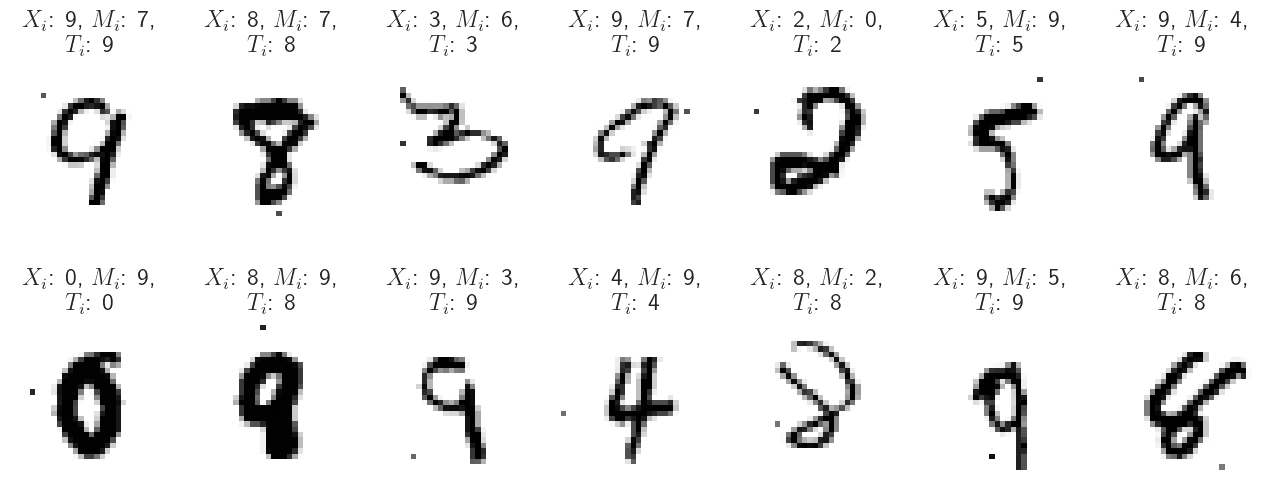

(10000, 1, 28, 28) (10000, 1, 28, 28)


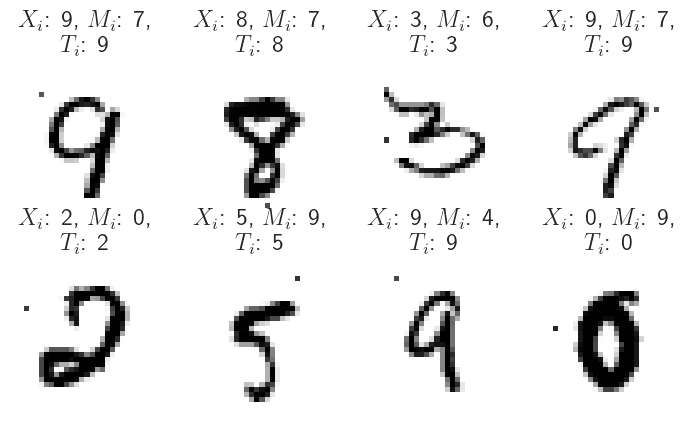

FloatProgress(value=0.0, max=375.0)

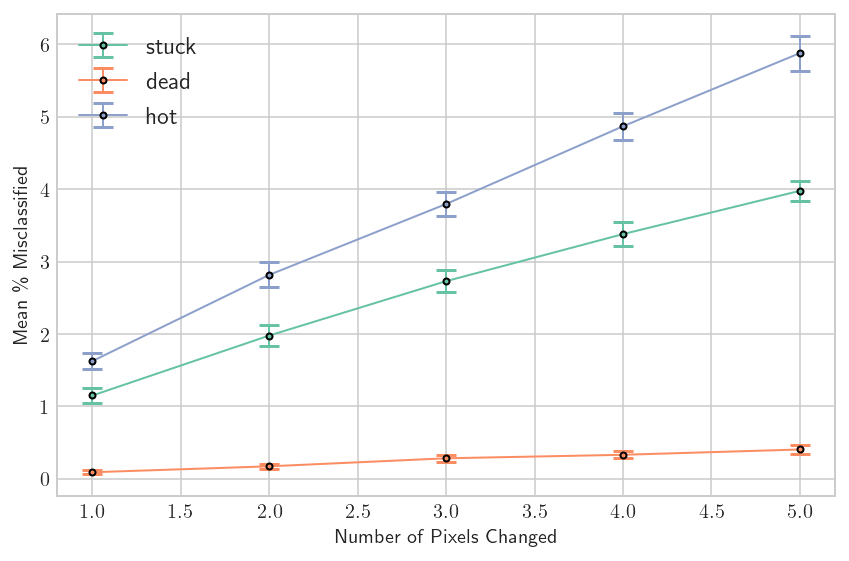

In [81]:
pixels_to_change = 1
Xcopy = per.change_pixel(Xtest, pixels_to_change=pixels_to_change)

diff_index, percent_diff = per.classified_diff(nnet, Xtest, Xcopy, Ttest)

print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by changing {pixels_to_change} pixel(s)''')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='MNIST', 
           name='media/mnist_example_single_1px.pdf')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='MNIST', 
           display='grid', name='media/mnist_example_grid_1px.pdf')

per.change_in_pixels_plot(nnet, Xtest, Ttest, end_pixel_val=5, 
                          trials_per_pixel=25, name='media/mnist_change_5px.pdf')

## CIFAR-10

In [9]:
!curl -O http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvf cifar-10-python.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  63.7M      0  0:00:02  0:00:02 --:--:-- 63.7M
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [16]:
def load(file_name):
    data = []
    
    for file in glob.glob('cifar-10-batches-py/' + file_name):
        with open(file, 'rb') as fo:
            data.append(pickle.load(fo, encoding='bytes'))
            
    images = np.array(data[0][b'data'])
    labels = np.array(data[0][b'labels'])

    if len(data) > 1:
        for i in range(1, len(data)):
            images = np.concatenate((images, data[i][b'data']), axis=0)
            labels = np.concatenate((labels, data[i][b'labels']), axis=0)
    
    return (images.reshape(-1, 3, 32, 32)/255.0).astype(np.float32), labels.reshape((-1, 1))

Xtrain, Ttrain = load('data_batch_*')
Xtest, Ttest, = load('test_batch')

print(Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape)
    
with open('cifar-10-batches-py/batches.meta', 'rb') as f:
    class_names = pickle.load(f, encoding='bytes')
class_names = class_names[b'label_names']

(50000, 3, 32, 32) (50000, 1) (10000, 3, 32, 32) (10000, 1)


In [75]:
nnet = nnc.NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[32, 64],
                                   kernels_size_and_stride=[(3, 1), (3, 1)],
                                   n_units_in_fc_hidden_layers=[], 
                                   classes=np.unique(Ttrain), use_gpu=True)

nnet.train(Xtrain, Ttrain, 100, optim='Adam', learning_rate=0.001, verbose=True)

RuntimeError: CUDA out of memory. Tried to allocate 5.37 GiB (GPU 0; 11.93 GiB total capacity; 7.67 GiB already allocated; 1.24 GiB free; 179.84 MiB cached)

In [ ]:
plt.plot(nnet.get_error_trace());

In [ ]:
train_percent = ml.percent_correct(Ttrain, nnet.use(Xtrain)[0])

classes, Y    = nnet.use(Xtest)
test_percent  = ml.percent_correct(Ttest, classes)

print(f'Train Percentage: {train_percent:.3f}%, Test Percentage: {test_percent:.3f}%')

In [ ]:
pixels_to_change = 1
Xcopy = per.change_pixel(Xtest, pixels_to_change=pixels_to_change)

diff_index, percent_diff = per.classified_diff(nnet, Xtest, Xcopy, Ttest)

print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by changing {pixels_to_change} pixel(s)''')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='CIFAR',
           name='media/cifar_example_single_1px_stuck.pdf')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='CIFAR',
           display='grid', name='media/cifar_example_grid_1px_stuck.pdf')

print(class_names)

per.change_in_pixels_plot(nne, Xtest, Ttest, end_pixel_val=5,
                          errorbar=True, pertrub='stuck',trials_per_pixel=25, 
                          name='media/cifar_change_5px_stuck.pdf')

## OTHER